<a href="https://colab.research.google.com/github/akashrajayush/cancer.prediction/blob/main/Copy_of_Chest_X_Ray_Images_(Pneumonia)_%7C_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:


import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'chest-xray-pneumonia:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F17810%2F23812%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240405%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240405T191436Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2629b61822fef5d1f4f68026b9acb50dfb99d6af04a477f5756fc629621a0bb2a5a9de582b666b261d8566a8d2b69f6b3c2ade33938468147c6797233168171c13618d83acd8c8ca8ebb5f4a2f44c7fba9b39ed204aebf420c74f62c97c41a76bfc043838c8538dac430cc536b447333ae1fc94112a15a63c349ca492033a6ae4db98c06a382bd61c743f378839b40e56ead1dff2c211f2c99f3beb037cc84849fa3fcf021fe57470ca25b5fdb08be3cd341c8dae296ce3c8dfd76ce61a0812bf062bfdea020bc58b52fa5c7df4bc392e5ad7980cbdd0a0e9bf28116187192dfbd7e2fde70660bb5ec843f189e2465302a797014a1671ae3cffb987637f34f13'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2463365435 bytes downloaded
Downloaded and uncompressed: chest-xray-pneumonia
Data source import complete.


# **Importing Modules**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import PIL
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# **Loading Data**

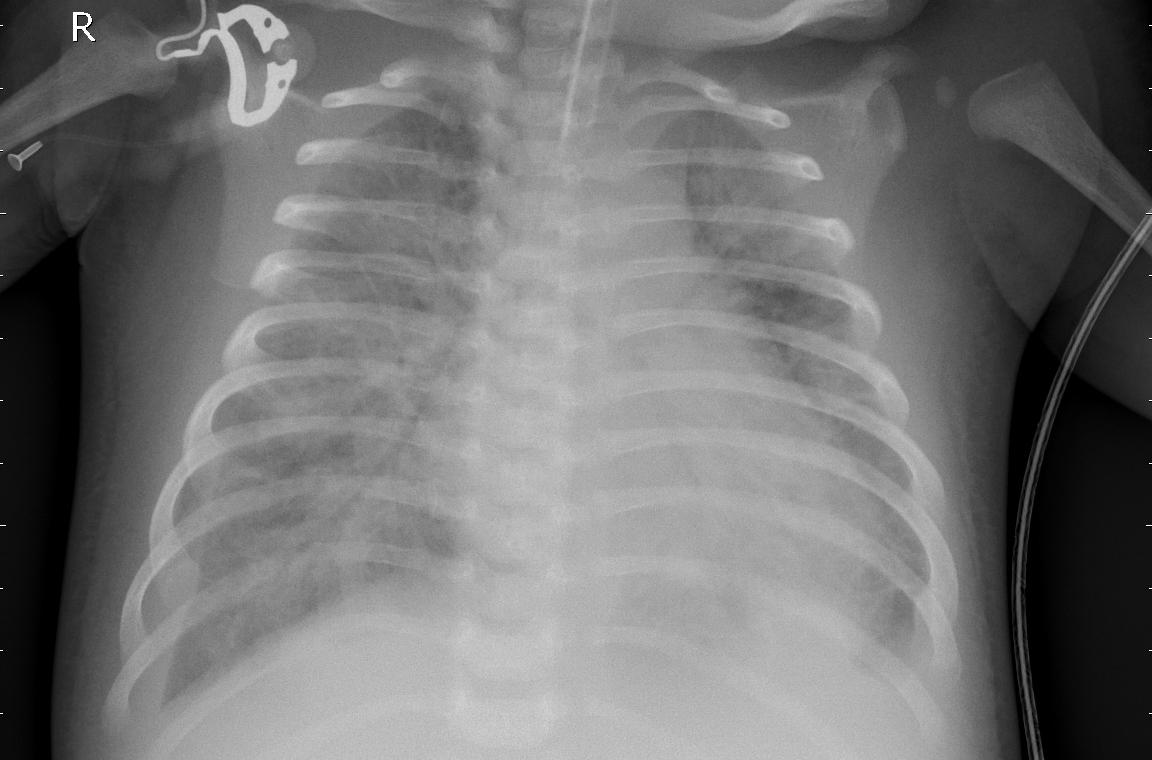

In [ ]:
image = PIL.Image.open('/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg')
image

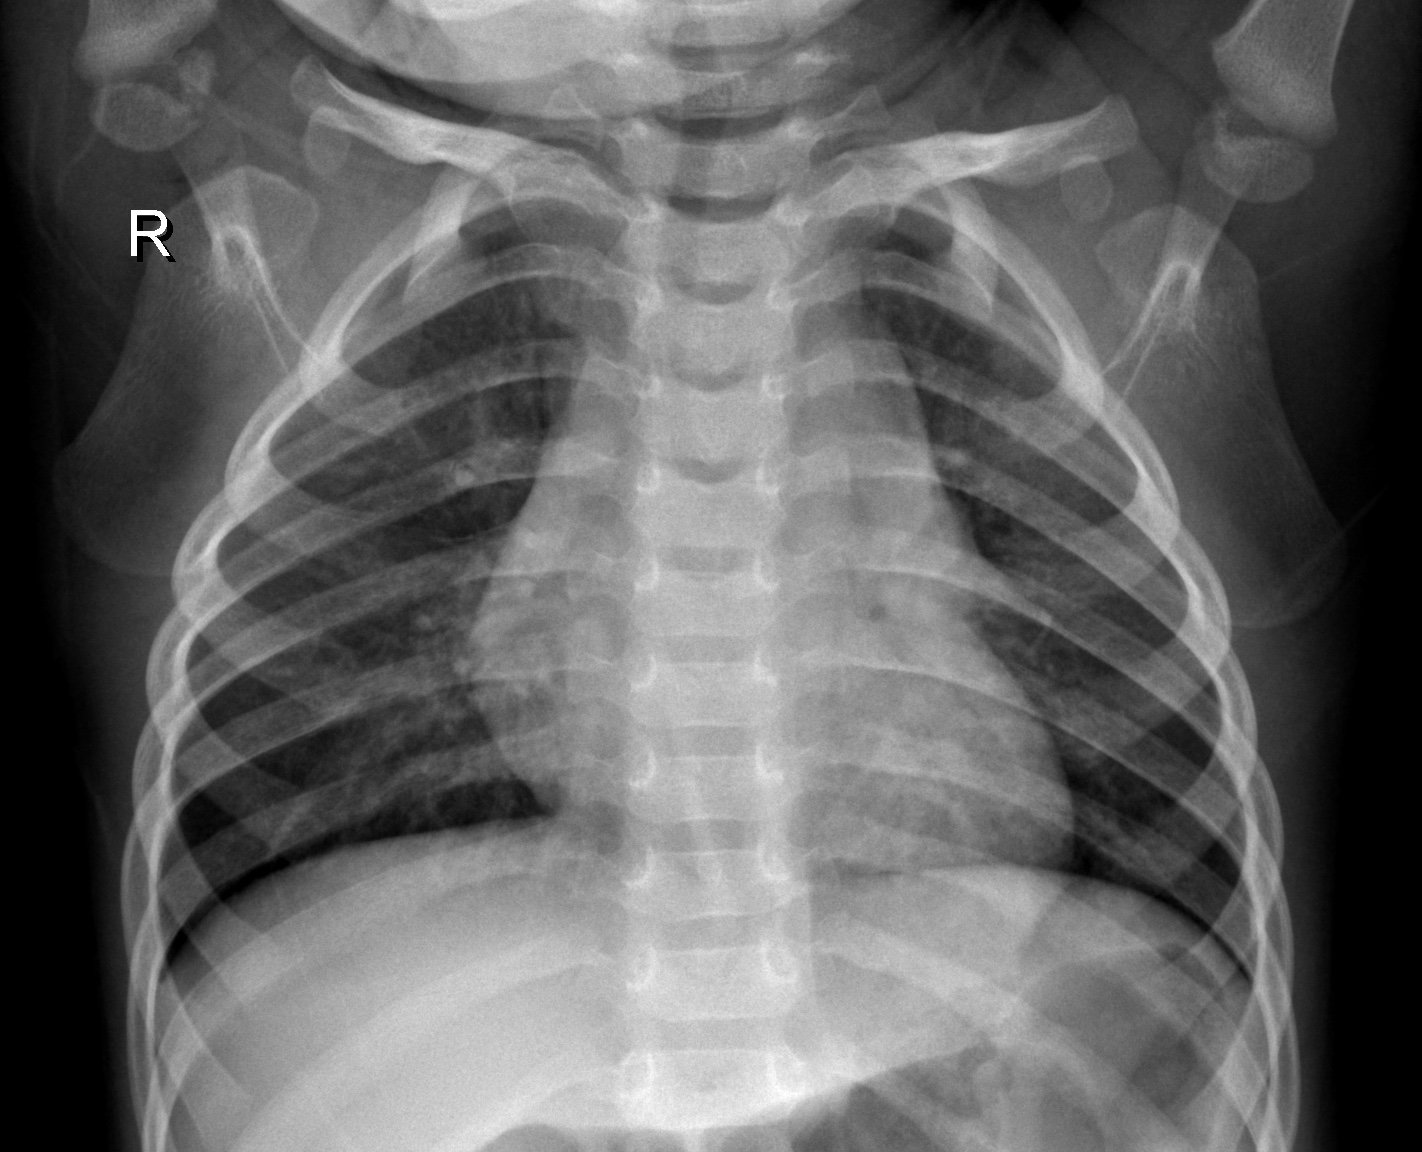

In [ ]:
image_normal = PIL.Image.open('/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0117-0001.jpeg')
image_normal

In [ ]:
train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
training_generator = ImageDataGenerator(rescale = 1/255)
train_data = training_generator.flow_from_directory(train_dir, target_size=(120,120), batch_size=8, class_mode='binary')

Found 5216 images belonging to 2 classes.


In [ ]:
valid_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'
validation_generator = ImageDataGenerator(rescale = 1/255)
valid_data = validation_generator.flow_from_directory(valid_dir, target_size=(120,120), batch_size=8, class_mode='binary')

Found 16 images belonging to 2 classes.


In [ ]:
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'
testing_generator = ImageDataGenerator(rescale = 1/255)
test_data = testing_generator.flow_from_directory(test_dir, target_size=(120,120), batch_size=8, class_mode='binary')

Found 624 images belonging to 2 classes.


# **CNN**

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), input_shape=(120,120,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 59, 59, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 28, 28, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 128)       0

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])

In [ ]:
history = model.fit(train_data, epochs=10, validation_data=valid_data)

Epoch 1/10
652/652 [==============================] - 217s 330ms/step - loss: 0.3278 - acc: 0.8570 - val_loss: 1.0013 - val_acc: 0.5625
Epoch 2/10
652/652 [==============================] - 212s 325ms/step - loss: 0.1784 - acc: 0.9317 - val_loss: 0.6289 - val_acc: 0.7500
Epoch 3/10
652/652 [==============================] - 216s 331ms/step - loss: 0.1100 - acc: 0.9559 - val_loss: 1.1021 - val_acc: 0.7500
Epoch 4/10
652/652 [==============================] - 211s 324ms/step - loss: 0.0933 - acc: 0.9651 - val_loss: 0.7875 - val_acc: 0.8125
Epoch 5/10
652/652 [==============================] - 212s 326ms/step - loss: 0.0816 - acc: 0.9707 - val_loss: 0.6296 - val_acc: 0.6875
Epoch 6/10
652/652 [==============================] - 214s 328ms/step - loss: 0.0708 - acc: 0.9728 - val_loss: 0.6416 - val_acc: 0.8750
Epoch 7/10
652/652 [==============================] - 213s 327ms/step - loss: 0.0498 - acc: 0.9826 - val_loss: 0.4055 - val_acc: 0.8750
Epoch 8/10
652/652 [============================

In [ ]:
model.evaluate(test_data)

78/78 [==============================] - 10s 132ms/step - loss: 1.6262 - acc: 0.7965


[1.626188039779663, 0.7964743375778198]

In [ ]:
predictions = model.predict(test_data)

78/78 [==============================] - 11s 136ms/step


1/1 [==============================] - 0s 170ms/step


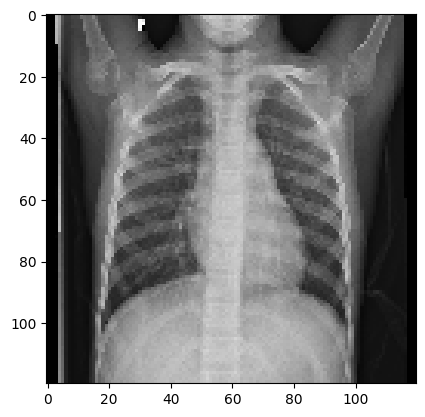

The probability of Pneumonia is:  [9.3394694e-05]


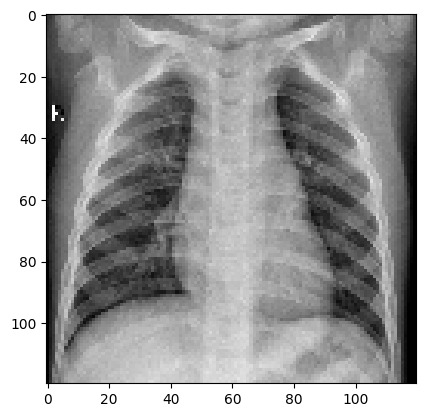

The probability of Pneumonia is:  [0.03176187]


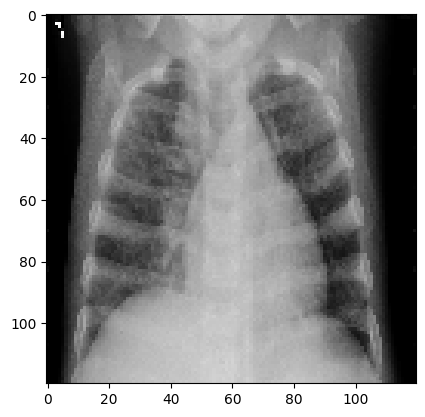

The probability of Pneumonia is:  [0.9999996]


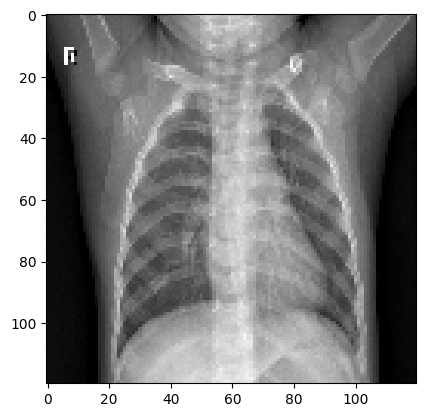

The probability of Pneumonia is:  [0.01649968]


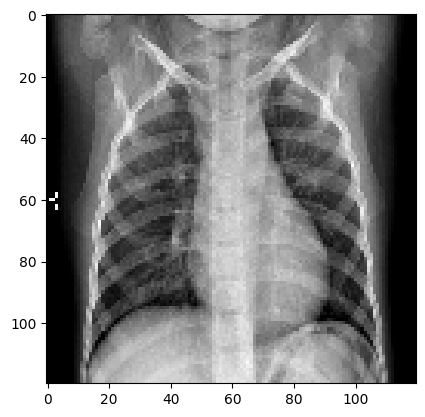

The probability of Pneumonia is:  [0.02635439]


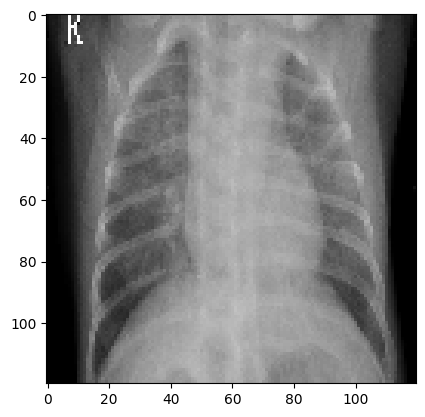

The probability of Pneumonia is:  [1.]


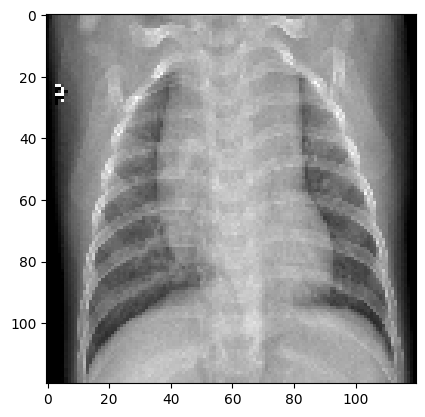

The probability of Pneumonia is:  [0.99910045]


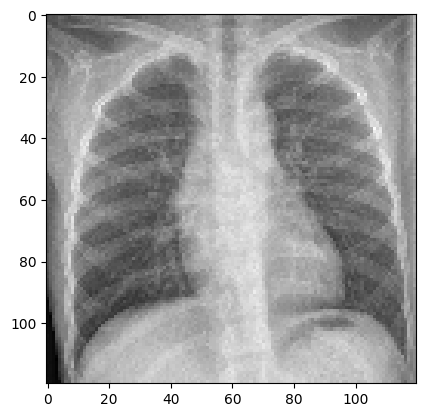

The probability of Pneumonia is:  [0.82399523]


In [ ]:
batch_size = test_data.batch_size
num_batches = 1

for i in range(num_batches):
    x, y = next(test_data)
    predictions = model.predict(x)

    for j in range(min(batch_size, 8)):
        image = x[j]
        plt.imshow(image)
        plt.show()
        print('The probability of Pneumonia is: ', predictions[j])